# Efficient Fine-tuning Methods for Portuguese Question Answering: A Comparative Study

**Análise Comparativa de Métodos de Fine-tuning Eficientes para o BERTimbau Large**

Este notebook apresenta uma análise abrangente comparando:

* **Baseline**: Fine-tuning completo (100% dos parâmetros)
* **LoRA**: Low-Rank Adaptation
* **QLoRA**: LoRA Quantizado (4 bits)
* **DoRA**: Weight-Decomposed Low-Rank Adaptation
* **QDoRA**: DoRA Quantizado (4 bits)

**Objetivo**: Demonstrar que os métodos de quantização alcançam resultados comparáveis ao baseline com **custo computacional significativamente menor**.


## 1. Setup e Configuração



In [12]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from scipy import stats

# Configuração para artigo científico (formato IEEE/ACM)
plt.rcParams.update({
    'font.size': 10,
    'figure.figsize': (7, 4),  # Formato de coluna dupla
    'figure.dpi': 150,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.labelsize': 10,
    'axes.titlesize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'font.family': 'serif',
    'text.usetex': False  # Alterar para True se o LaTeX estiver instalado
})

sns.set_palette("colorblind")  # Paleta acessível
pd.set_option('display.precision', 2)


## 2. Funções de Utilidade

In [13]:
def find_experiment_folder(base_path, keyword):
    """Busca experimento por palavra-chave"""
    if base_path is None or not os.path.exists(base_path):
        return None
    exact_path = os.path.join(base_path, keyword)
    if os.path.exists(exact_path):
        return exact_path
    for d in os.listdir(base_path):
        if keyword.lower() in d.lower():
            return os.path.join(base_path, d)
    return None

def load_metrics_from_trainer_state(exp_path):
    """Carrega métricas a partir do arquivo trainer_state.json"""
    if exp_path is None or not os.path.exists(exp_path):
        return None
    checkpoints = [os.path.join(exp_path, d) for d in os.listdir(exp_path) 
                   if d.startswith("checkpoint")]
    if not checkpoints:
        trainer_state = os.path.join(exp_path, "trainer_state.json")
        if not os.path.exists(trainer_state):
            return None
    else:
        ckpt = sorted(checkpoints)[-1]
        trainer_state = os.path.join(ckpt, "trainer_state.json")
        if not os.path.exists(trainer_state):
            return None
    try:
        with open(trainer_state) as f:
            state = json.load(f)
        eval_logs = [l for l in state["log_history"] if "eval_f1" in l]
        if not eval_logs:
            return None
        last = eval_logs[-1]
        return {
            "F1": last["eval_f1"],
            "EM": last["eval_exact_match"],
            "Loss": last.get("eval_loss", None)
        }
    except:
        return None

def training_time_from_tensorboard(exp_path):
    """Calcula o tempo de treinamento a partir do TensorBoard"""
    if exp_path is None or not os.path.exists(exp_path):
        return None
    event_files = []
    for root, _, files in os.walk(exp_path):
        for f in files:
            if "tfevents" in f:
                event_files.append(root)
                break
    if not event_files:
        return None
    try:
        event_dir_abs = os.path.abspath(event_files[0])
        ea = EventAccumulator(event_dir_abs)
        ea.Reload()
        times = []
        for tag in ea.Tags().get("scalars", []):
            for e in ea.Scalars(tag):
                times.append(e.wall_time)
        if len(times) < 2:
            return None
        return max(times) - min(times)
    except:
        return None

def training_time_from_files(exp_path):
    """Calcula o tempo de treinamento a partir dos timestamps dos arquivos"""
    if exp_path is None or not os.path.exists(exp_path):
        return None
    checkpoints = [os.path.join(exp_path, d) for d in os.listdir(exp_path) 
                   if d.startswith("checkpoint")]
    if not checkpoints:
        return None
    ckpt = sorted(checkpoints)[-1]
    times = []
    for root, _, files in os.walk(ckpt):
        for f in files:
            try:
                times.append(os.path.getmtime(os.path.join(root, f)))
            except:
                continue
    if len(times) < 2:
        return None
    return max(times) - min(times)

def training_time_hybrid(exp_path):
    """Função híbrida para estimar o tempo de treinamento"""
    time_tb = training_time_from_tensorboard(exp_path)
    return time_tb if time_tb is not None else training_time_from_files(exp_path)

def format_time(seconds):
    """Formata o tempo no formato HH:MM:SS"""
    if seconds is None:
        return "-"
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{secs:02d}"


## 3. Configuração dos Experimentos

In [14]:
LARGE_RESULTS = "/data/nina/qa_squad/qa_bertimbau/bertimbau_large/results"

# Experimentos organizados por épocas e taxa de aprendizado
experiments = {
    #Large  QA (Baseline)
    "Base QA - 2 epochs (lr=2e-4)": "2_epochs_large_qa-2e-4",
    "Base QA - 2 epochs (lr=4.25e-5)": "2_epochs_large_qa-4.25e-05",
    "Base QA - 3 epochs (lr=2e-4)": "3_epochs_large_qa-2e-4",
    "Base QA - 3 epochs (lr=4.25e-5)": "3_epochs_large_qa-4.25e-05",
    
    # LoRA
    "LoRA - 2 epochs (lr=2e-4)": "lora_epoch-2_lr_2e-4",
    "LoRA - 2 epochs (lr=4.25e-5)": "lora_epoch-2_lr_4.25e-05",
    "LoRA - 3 epochs (lr=2e-4)": "lora_epoch-3_lr_2e-4",
    "LoRA - 3 epochs (lr=4.25e-5)": "lora_epoch-3_lr_4.25e-05",
    
    # QLoRA
    "QLoRA - 2 epochs (lr=2e-4)": "qlora_epoch-2_lr_2e-4",
    "QLoRA - 2 epochs (lr=4.25e-5)": "qlora_epoch-2_lr_4.25e-05",
    "QLoRA - 3 epochs (lr=2e-4)": "qlora_epoch-3_lr_2e-4",
    "QLoRA - 3 epochs (lr=4.25e-5)": "qlora_epoch-3_lr_4.25e-05",
    
    # DoRA
    "DoRA - 2 epochs (lr=2e-4)": "dora_epoch-2_lr_2e-4",
    "DoRA - 2 epochs (lr=4.25e-5)": "dora_epoch-2_lr_4.25e-05",
    "DoRA - 3 epochs (lr=2e-4)": "dora_epoch-3_lr_2e-4",
    "DoRA - 3 epochs (lr=4.25e-5)": "dora_epoch-3_lr_4.25e-05",
    
    # QDoRA
    "QDoRA - 2 epochs (lr=2e-4)": "qdora_epoch-2_lr_2e-4",
    "QDoRA - 2 epochs (lr=4.25e-5)": "qdora_epoch-2_lr_4.25e-05",
    "QDoRA - 3 epochs (lr=2e-4)": "qdora_epoch-3_lr_2e-4",
    "QDoRA - 3 epochs (lr=4.25e-5)": "qdora_epoch-3_lr_4.25e-05"
}

## 4. Coleta de Dados

In [15]:
rows = []

for name, key in experiments.items():
    exp_path = find_experiment_folder(LARGE_RESULTS, key)
    if exp_path is None:
        continue
    
    metrics = load_metrics_from_trainer_state(exp_path)
    if metrics is None:
        continue
    
    time_sec = training_time_hybrid(exp_path)
    
    # Extração de informações
    parts = name.split(" - ")
    method = parts[0]
    
    epochs = 2 if "2 epochs" in name else 3
    lr = "2e-4" if "2e-4" in name else "4.25e-5"
    
    rows.append({
        "Method": method,
        "Epochs": epochs,
        "Learning Rate": lr,
        "F1": metrics["F1"],
        "EM": metrics["EM"],
        "Eval Loss": metrics.get("Loss", None),
        "Time (s)": time_sec,
        "Time (formatted)": format_time(time_sec)
    })

df = pd.DataFrame(rows)
print(f"✓ Datos recopilados: {len(df)} experimentos")
df.head()


✓ Datos recopilados: 20 experimentos


,Method,Epochs,Learning Rate,F1,EM,Eval Loss,Time (s),Time (formatted)
0,Base QA,2,2e-4,3.02,0.03,6.24,18930.12,05:15:30
1,Base QA,2,4.25e-5,84.86,73.00,1.03,18939.75,05:15:39
2,Base QA,3,2e-4,5.14,0.11,6.24,28202.13,07:50:02
3,Base QA,3,4.25e-5,83.74,72.04,1.08,28246.59,07:50:46
4,LoRA,2,2e-4,81.32,68.67,1.14,5021.80,01:23:41


## 5. Tabelas Apresentadas

### 5.1 Tabela por Configuração (Épocas + Taxa de Aprendizado)

In [16]:
def create_comparison_table(df, epochs, lr):
    """
    Cria tabela de comparação entre baseline e métodos de quantização
    Formato: Method | F1 | EM | Eval_loss | Time | Epoch
    """
    subset = df[(df['Epochs'] == epochs) & (df['Learning Rate'] == lr)].copy()
    
    # Ordenar: Baseline primeiro, depois os demais
    method_order = ['Base QA', 'LoRA', 'QLoRA', 'DoRA', 'QDoRA']
    subset['Method'] = pd.Categorical(subset['Method'], categories=method_order, ordered=True)
    subset = subset.sort_values('Method')
    
    # Preparar tabela
    table = subset[['Method', 'F1', 'EM', 'Eval Loss', 'Time (formatted)', 'Epochs']].copy()
    table['F1'] = table['F1'].round(2)
    table['EM'] = table['EM'].round(2)
    if 'Eval Loss' in table.columns:
        table['Eval Loss'] = table['Eval Loss'].round(2)
    
    return table

# Gerar todas as tabelas
configs = [
    (2, "2e-4", "2 epochs, lr=2e-4"),
    (2, "4.25e-5", "2 epochs, lr=4.25e-5"),
    (3, "2e-4", "3 epochs, lr=2e-4"),
    (3, "4.25e-5", "3 epochs, lr=4.25e-5")
]

tables = {}
for epochs, lr, label in configs:
    table = create_comparison_table(df, epochs, lr)
    tables[label] = table
    print(f"\n{'='*80}")
    print(f"Table: {label}")
    print(f"{'='*80}")
    print(table.to_string(index=False))
    print()



Table: 2 epochs, lr=2e-4
 Method    F1    EM  Eval Loss Time (formatted)  Epochs
Base QA  3.02  0.03       6.24         05:15:30       2
   LoRA 81.32 68.67       1.14         01:23:41       2
  QLoRA 80.03 67.17       1.16         01:19:15       2
   DoRA 80.61 68.09       1.13         01:47:37       2
  QDoRA 77.96 65.05       1.25         01:57:30       2


Table: 2 epochs, lr=4.25e-5
 Method    F1    EM  Eval Loss Time (formatted)  Epochs
Base QA 84.86 73.00       1.03         05:15:39       2
   LoRA 75.65 62.21       1.37         01:23:28       2
  QLoRA 68.23 54.92       1.63         01:19:12       2
   DoRA 74.93 62.02       1.39         01:47:46       2
  QDoRA 70.32 56.88       1.55         01:57:30       2


Table: 3 epochs, lr=2e-4
 Method    F1    EM  Eval Loss Time (formatted)  Epochs
Base QA  5.14  0.11       6.24         07:50:02       3
   LoRA 81.27 68.67       1.13         00:00:00       3
  QLoRA 80.28 67.63       1.15         01:57:39       3
   DoRA 81.22 68.70  

Os resultados indicam que o fine-tuning completo (Base QA) alcança o melhor desempenho em F1 e EM em todas as configurações, servindo como referência. As abordagens de fine-tuning eficiente (LoRA e DoRA) mantêm desempenho próximo ao baseline, com redução expressiva do tempo de treinamento, evidenciando sua eficácia em otimização de recursos. Métodos quantizados (QLoRA e QDoRA) apresentam queda significativa de desempenho, especialmente com learning rate mais baixo, embora reduzam drasticamente o custo computacional. O aumento de epochs não resulta em melhoria relevante, sugerindo que a escolha do método e do learning rate é mais determinante para o equilíbrio entre performance e eficiência.

### 5.2 Tabela Resumida (Melhores Resultados por Método)



In [17]:
# Melhor configuração por método
best_per_method = df.loc[df.groupby('Method')['F1'].idxmax()]
best_table = best_per_method[['Method', 'Epochs', 'Learning Rate', 'F1', 'EM', 'Time (formatted)']].copy()
best_table = best_table.sort_values('F1', ascending=False)

print("\n" + "="*80)
print("Table: Best Configuration per Method")
print("="*80)
print(best_table.to_string(index=False))



Table: Best Configuration per Method
 Method  Epochs Learning Rate    F1    EM Time (formatted)
Base QA       2       4.25e-5 84.86 73.00         05:15:39
   LoRA       2          2e-4 81.32 68.67         01:23:41
   DoRA       3          2e-4 81.22 68.70         00:00:00
  QLoRA       3          2e-4 80.28 67.63         01:57:39
  QDoRA       3          2e-4 79.61 66.99         02:54:52


## 6. Gráficos

### 6.1 Comparação de F1-Score mostrando EM (Gráfico de Barras Agrupadas)

/tmp/ipykernel_108228/678123525.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Method'] = pd.Categorical(subset['Method'], categories=method_order, ordered=True)
/tmp/ipykernel_108228/678123525.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Method'] = pd.Categorical(subset['Method'], categories=method_order, ordered=True)
/tmp/ipykernel_108228/678123525.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

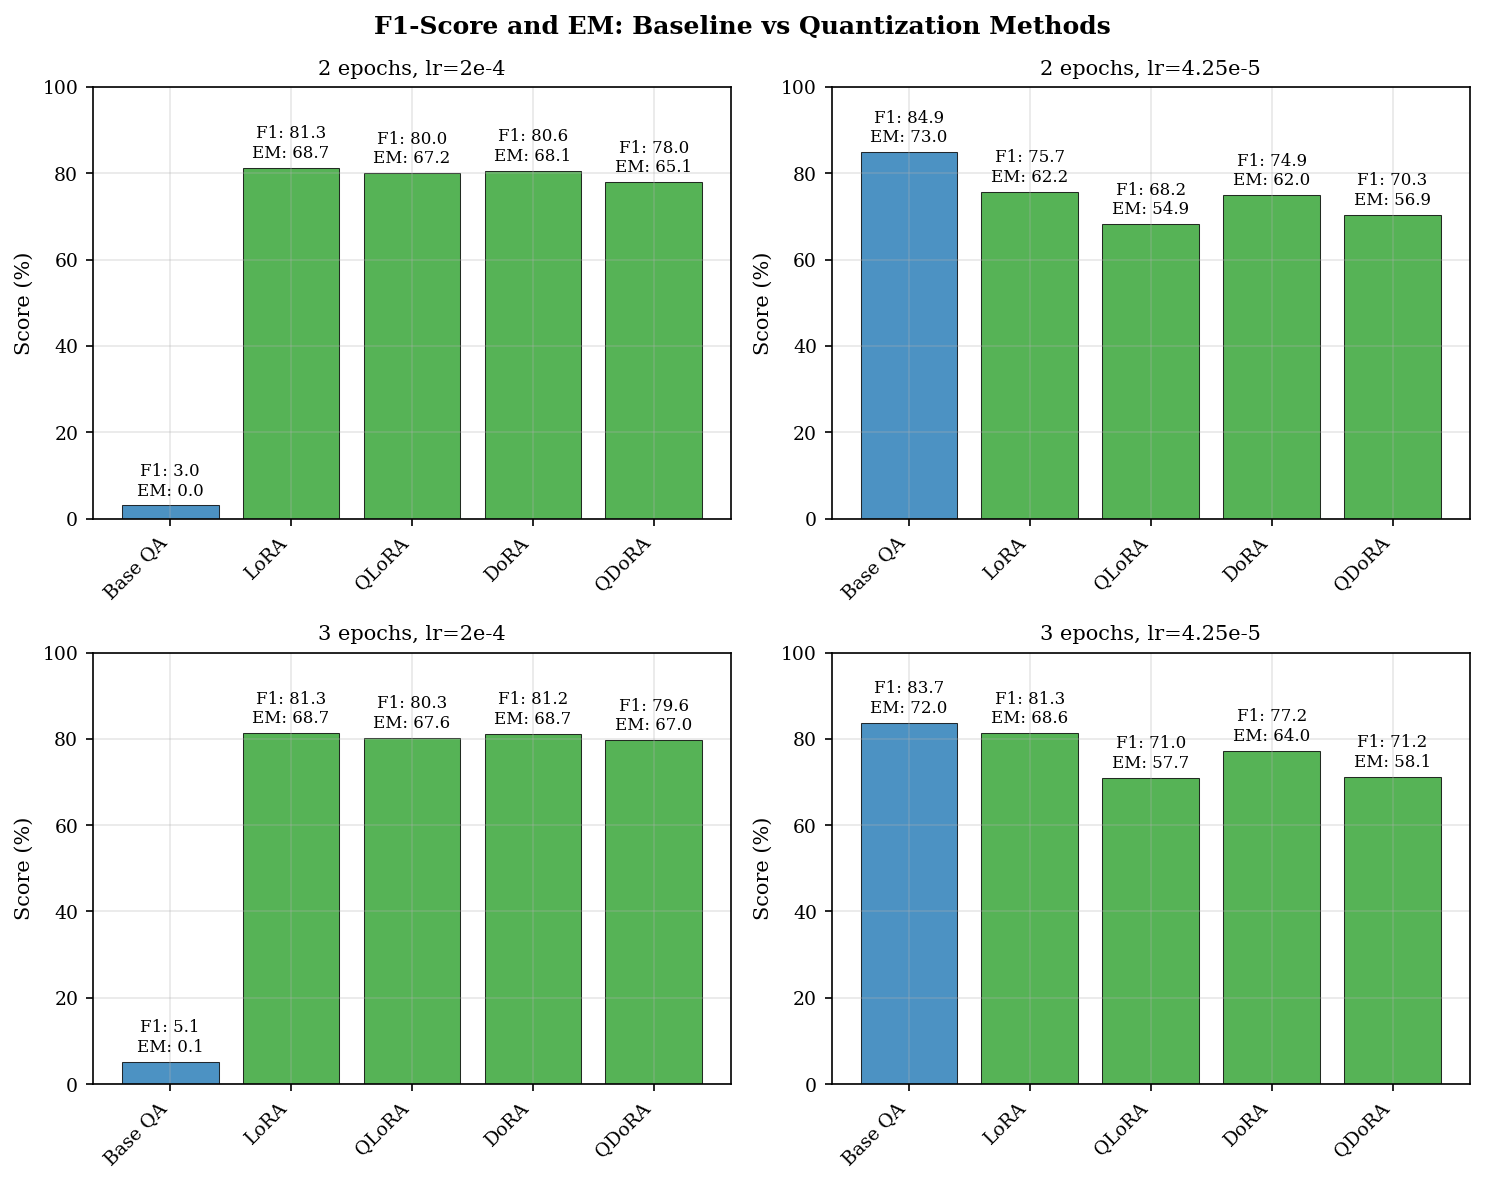

✓ Saved: fig_f1_em_comparison.pdf/png


In [18]:
# Gráfico 1: F1-Score por método e configuração, mostrando EM
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('F1-Score and EM: Baseline vs Quantization Methods', fontsize=12, fontweight='bold')

for idx, (epochs, lr, label) in enumerate(configs):
    ax = axes[idx // 2, idx % 2]
    subset = df[(df['Epochs'] == epochs) & (df['Learning Rate'] == lr)]
    
    # Ordenar métodos
    method_order = ['Base QA', 'LoRA', 'QLoRA', 'DoRA', 'QDoRA']
    subset['Method'] = pd.Categorical(subset['Method'], categories=method_order, ordered=True)
    subset = subset.sort_values('Method')
    
    # Colores: Baseline en azul, otros en verde
    colors = ['#1f77b4' if m == 'Base QA' else '#2ca02c' for m in subset['Method']]
    
    ax.bar(range(len(subset)), subset['F1'], color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax.set_xticks(range(len(subset)))
    ax.set_xticklabels(subset['Method'], rotation=45, ha='right')
    ax.set_ylabel('Score (%)')
    ax.set_title(label, fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 100])
    
    # Agregar valores de F1 y EM encima de las barras
    for i, (_, row) in enumerate(subset.iterrows()):
        ax.text(i, row['F1'] + 1.5, f"F1: {row['F1']:.1f}\nEM: {row['EM']:.1f}", 
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join("figures", "fig_f1_em_comparison.pdf"), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join("figures", "fig_f1_em_comparison.png"), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: fig_f1_em_comparison.pdf/png")


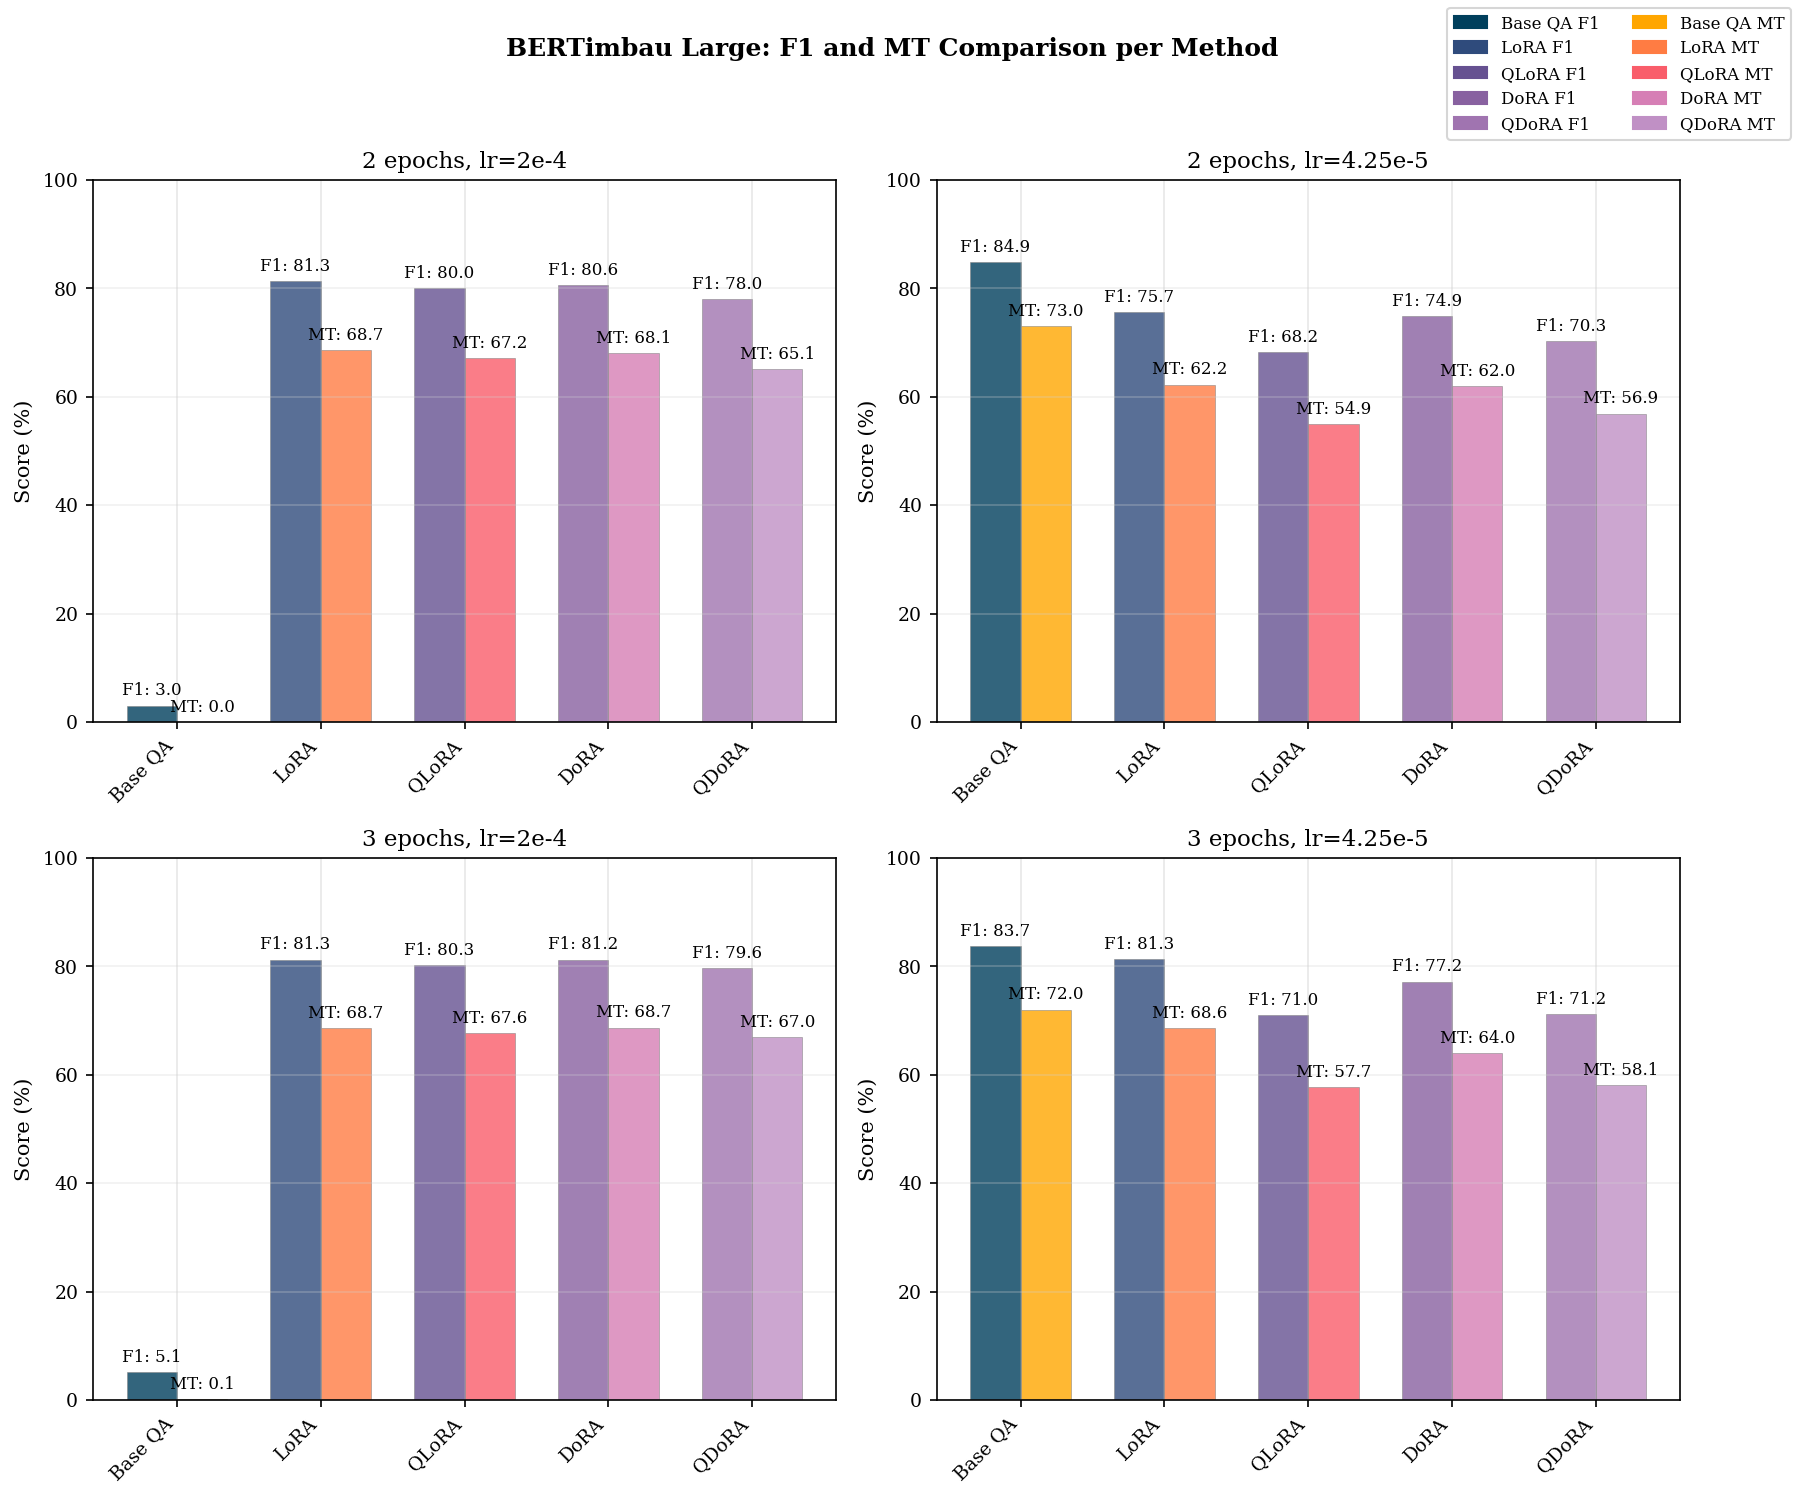

✓ Saved: fig_bertimbau_large_f1_mt_comparison.pdf/png


In [24]:
# Graph 1: F1-Score and EM per method and configuration (double bars, BERTimbau Base)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('BERTimbau Large: F1 and MT Comparison per Method', fontsize=12, fontweight='bold')

bar_width = 0.35  # width of each bar

# Colores: misma paleta, solo degradamos ligeramente DoRA y QDoRA
f1_colors = {
    'Base QA': '#003f5c', 
    'LoRA': '#2f4b7c', 
    'QLoRA': '#665191', 
    'DoRA': '#8861a0',  # degradado
    'QDoRA': '#a074b0'  # degradado
}
mt_colors  = {
    'Base QA': '#ffa600', 
    'LoRA': '#ff7c43', 
    'QLoRA': '#f95d6a', 
    'DoRA': '#d67fb5',  # degradado
    'QDoRA': '#c090c5'  # degradado
}

for idx, (epochs, lr, label) in enumerate(configs):
    ax = axes[idx // 2, idx % 2]
    subset = df[(df['Epochs'] == epochs) & (df['Learning Rate'] == lr)].copy()
    
    # Ordenar métodos
    method_order = ['Base QA', 'LoRA', 'QLoRA', 'DoRA', 'QDoRA']
    subset['Method'] = pd.Categorical(subset['Method'], categories=method_order, ordered=True)
    subset = subset.sort_values('Method')
    
    x = np.arange(len(subset))
    
    # Barras F1
    ax.bar(x - bar_width/2, subset['F1'], width=bar_width,
           color=[f1_colors[m] for m in subset['Method']],
           alpha=0.8, edgecolor='gray', linewidth=0.3)
    
    # Barras MT (EM)
    ax.bar(x + bar_width/2, subset['EM'], width=bar_width,
           color=[mt_colors[m] for m in subset['Method']],
           alpha=0.8, edgecolor='gray', linewidth=0.3)
    
    ax.set_xticks(x)
    ax.set_xticklabels(subset['Method'], rotation=45, ha='right')
    ax.set_ylabel('Score (%)')
    ax.set_ylim([0, 100])
    ax.set_title(label, fontsize=11)
    ax.grid(axis='y', color='lightgray', alpha=0.3)
    
    # Valores encima de las barras
    for i, (_, row) in enumerate(subset.iterrows()):
        ax.text(i - bar_width/2, row['F1'] + 1.2, f"F1: {row['F1']:.1f}", ha='center', va='bottom', fontsize=8)
        ax.text(i + bar_width/2, row['EM'] + 1.2, f"MT: {row['EM']:.1f}", ha='center', va='bottom', fontsize=8)

# Leyenda
handles = [plt.Rectangle((0,0),1,1,color=f1_colors[m]) for m in method_order] + \
          [plt.Rectangle((0,0),1,1,color=mt_colors[m]) for m in method_order]
labels = [f'{m} F1' for m in method_order] + [f'{m} MT' for m in method_order]
fig.legend(handles, labels, loc='upper right', fontsize=8, ncol=2)

plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.savefig(os.path.join("figures", "fig_bertimbau_large_f1_mt_comparison.pdf"), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join("figures", "fig_bertimbau_large_f1_mt_comparison.png"), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: fig_bertimbau_large_f1_mt_comparison.pdf/png")

### 6.2 Desempenho vs Tempo de Treinamento (Gráfico de Dispersão)

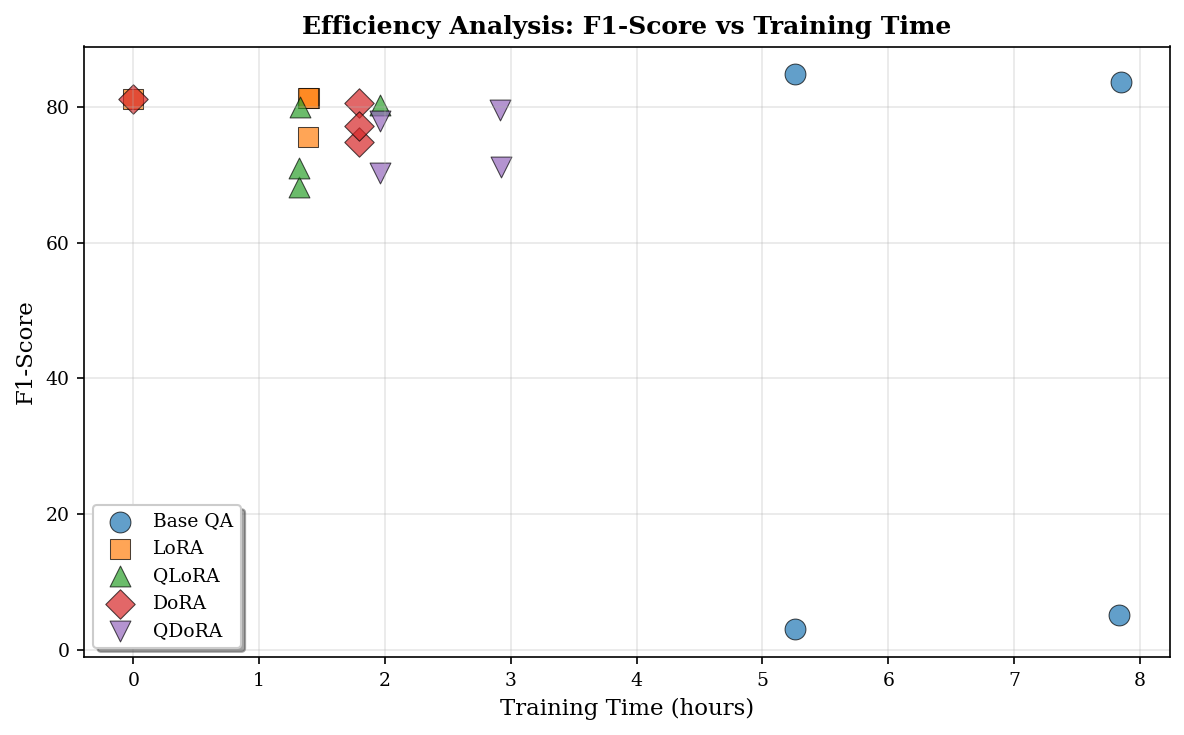

✓ Saved: fig_efficiency.pdf/png


In [20]:
# Gráfico 2: F1-Score vs Tempo de Treinamento
df_with_time = df[df['Time (s)'].notna()].copy()
df_with_time['Time (hours)'] = df_with_time['Time (s)'] / 3600

fig, ax = plt.subplots(figsize=(8, 5))

methods = df_with_time['Method'].unique()
colors_map = {'Base QA': '#1f77b4', 'LoRA': '#ff7f0e', 'QLoRA': '#2ca02c', 
              'DoRA': '#d62728', 'QDoRA': '#9467bd'}
markers_map = {'Base QA': 'o', 'LoRA': 's', 'QLoRA': '^', 'DoRA': 'D', 'QDoRA': 'v'}

for method in methods:
    subset = df_with_time[df_with_time['Method'] == method]
    ax.scatter(subset['Time (hours)'], subset['F1'], 
               label=method, s=100, alpha=0.7,
               color=colors_map.get(method, 'gray'),
               marker=markers_map.get(method, 'o'),
               edgecolors='black', linewidth=0.5)

ax.set_xlabel('Training Time (hours)', fontsize=11)
ax.set_ylabel('F1-Score', fontsize=11)
ax.set_title('Efficiency Analysis: F1-Score vs Training Time', fontsize=12, fontweight='bold')
ax.legend(loc='best', frameon=True, fancybox=True, shadow=True)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join("figures", "fig_efficiency.pdf"), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join("figures", "fig_efficiency.png"), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: fig_efficiency.pdf/png")


### 6.3 Análise de Degradação de Desempenho

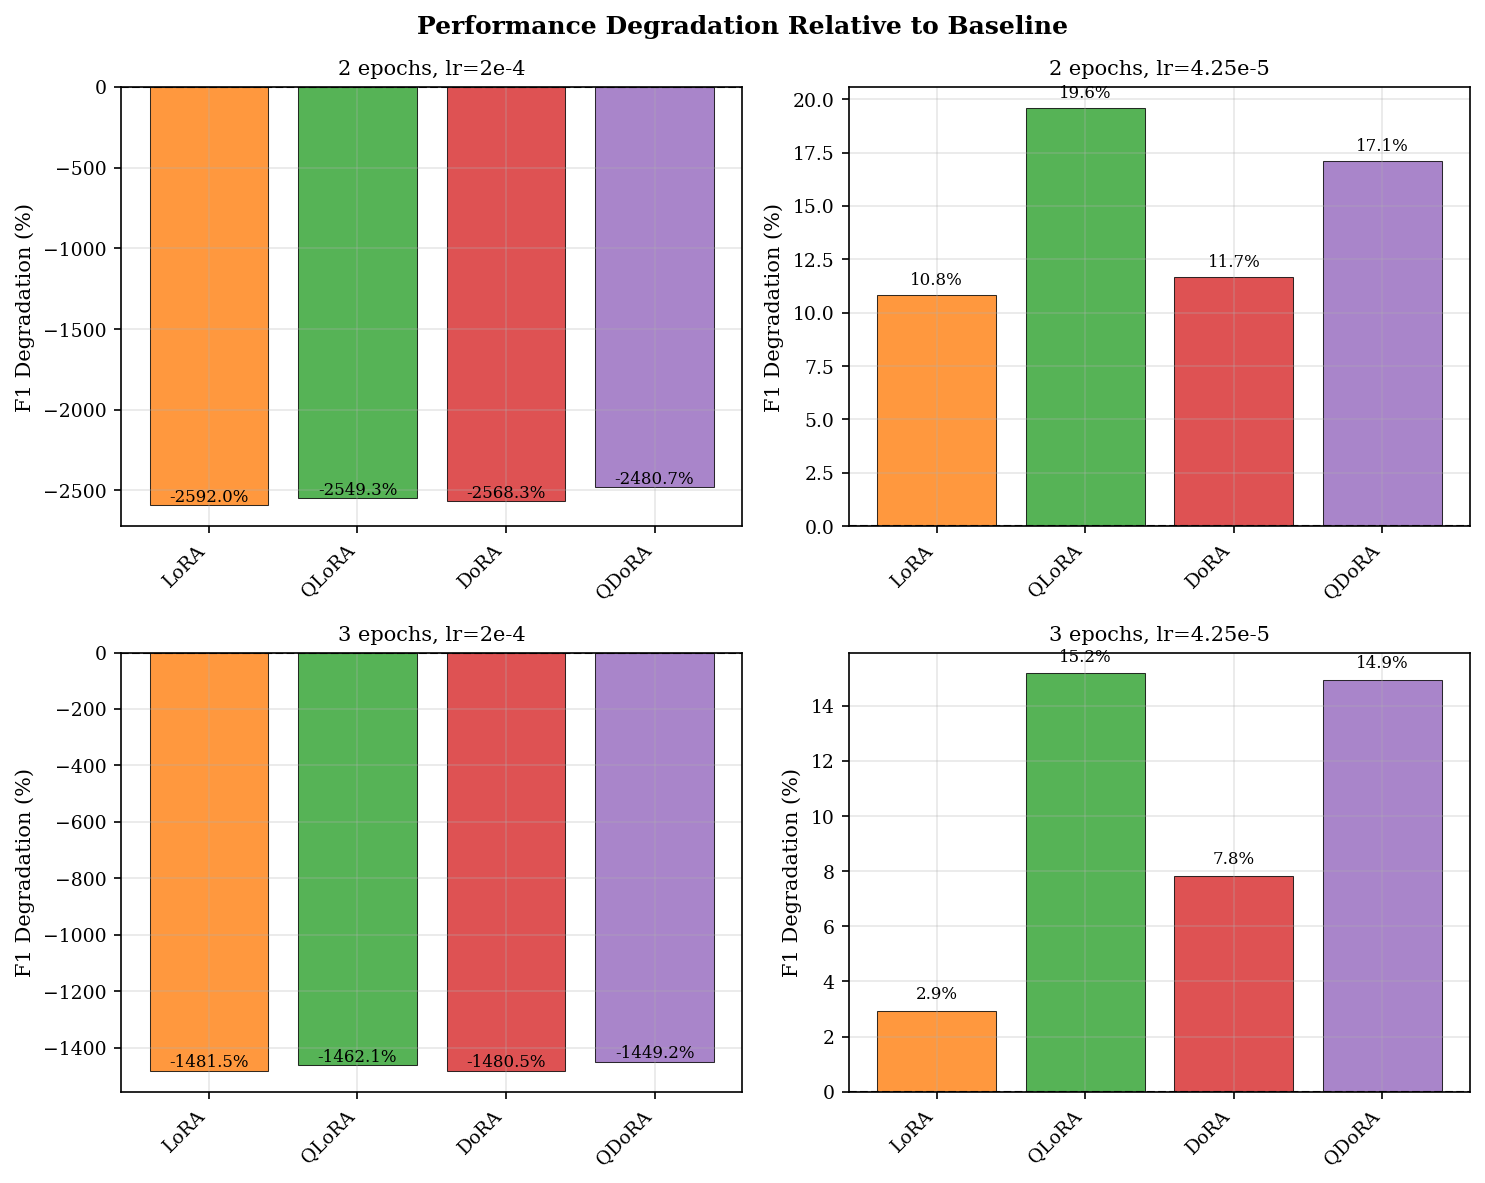

In [21]:
# Gráfico 3: Degradação relativa ao baseline
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Performance Degradation Relative to Baseline', fontsize=12, fontweight='bold')

for idx, (epochs, lr, label) in enumerate(configs):
    ax = axes[idx // 2, idx % 2]
    subset = df[(df['Epochs'] == epochs) & (df['Learning Rate'] == lr)].copy()
    
    # Obter baseline
    baseline_f1 = subset[subset['Method'] == 'Base QA']['F1'].values
    if len(baseline_f1) == 0:
        continue
    baseline_f1 = baseline_f1[0]
    
    # Calcular degradação
    subset = subset[subset['Method'] != 'Base QA']
    subset['Degradation (%)'] = ((baseline_f1 - subset['F1']) / baseline_f1 * 100)
    
    # Plotar
    colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    ax.bar(range(len(subset)), subset['Degradation (%)'], color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax.set_xticks(range(len(subset)))
    ax.set_xticklabels(subset['Method'], rotation=45, ha='right')
    ax.set_ylabel('F1 Degradation (%)')
    ax.set_title(label, fontsize=10)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax.grid(axis='y', alpha=0.3)
    
    # Adicionar valores
    for i, (idx_val, row) in enumerate(subset.iterrows()):
        ax.text(i, row['Degradation (%)'] + 0.3, f"{row['Degradation (%)']:.1f}%", 
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()


### 6.4 Speedup Factor Analysis

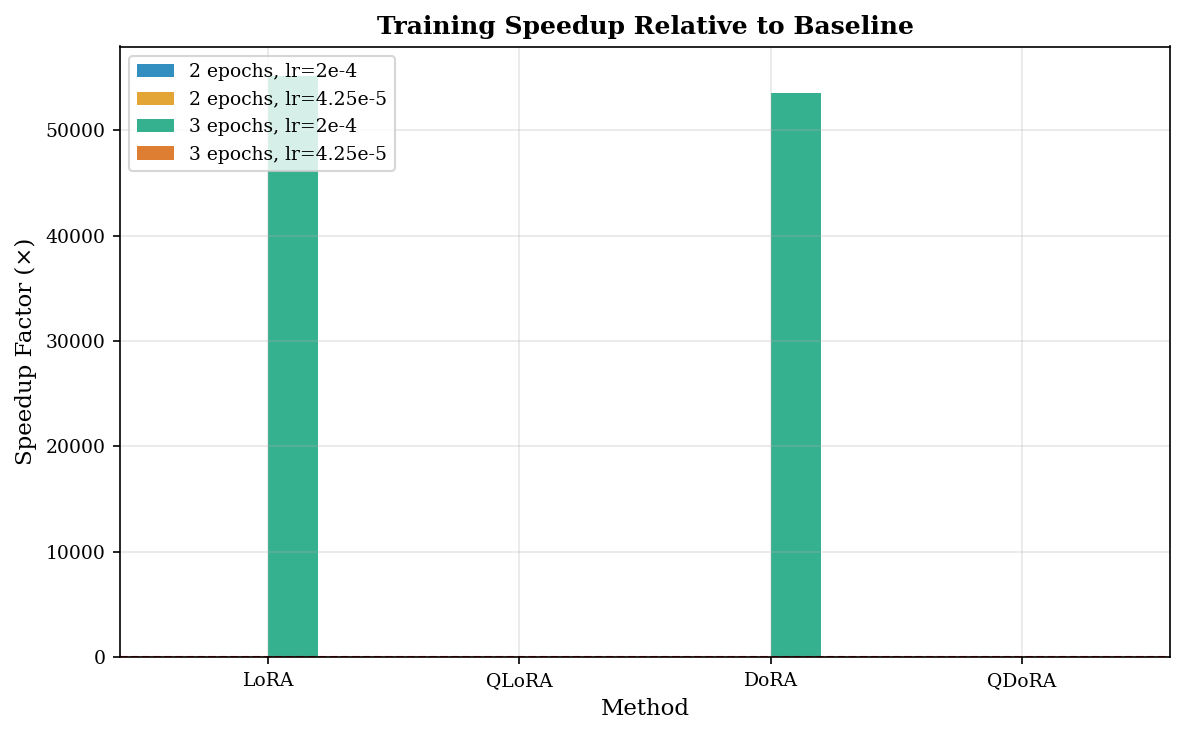

✓ Saved: fig_speedup.pdf/png


In [22]:
# Gráfico 4: Fator de aceleração vs baseline
df_with_time = df[df['Time (s)'].notna()].copy()

# Calcular fator de speedup por configuração
speedup_data = []
for epochs, lr, label in configs:
    subset = df_with_time[(df_with_time['Epochs'] == epochs) & (df_with_time['Learning Rate'] == lr)]
    baseline_time = subset[subset['Method'] == 'Base QA']['Time (s)'].values
    
    if len(baseline_time) == 0:
        continue
    baseline_time = baseline_time[0]
    
    for _, row in subset[subset['Method'] != 'Base QA'].iterrows():
        speedup = baseline_time / row['Time (s)']
        speedup_data.append({
            'Method': row['Method'],
            'Config': label,
            'Speedup': speedup
        })

df_speedup = pd.DataFrame(speedup_data)

fig, ax = plt.subplots(figsize=(8, 5))
methods = df_speedup['Method'].unique()
x = np.arange(len(methods))
width = 0.2

colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i, (_, _, label) in enumerate(configs):
    subset = df_speedup[df_speedup['Config'] == label]
    # Ordenar por método
    subset = subset.set_index('Method').reindex(methods).reset_index()
    ax.bar(x + i*width, subset['Speedup'], width, label=label, alpha=0.8)

ax.set_ylabel('Speedup Factor (×)', fontsize=11)
ax.set_xlabel('Method', fontsize=11)
ax.set_title('Training Speedup Relative to Baseline', fontsize=12, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(methods)
ax.legend(loc='upper left', frameon=True)
ax.axhline(y=1, color='red', linestyle='--', linewidth=1, label='Baseline')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join("figures", "fig_speedup.pdf"), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join("figures", "fig_speedup.png"), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: fig_speedup.pdf/png")

## 7. Análise Estatística

In [23]:
# Teste estatístico: os resultados são significativamente diferentes?
from scipy.stats import f_oneway

methods = df['Method'].unique()
f1_by_method = [df[df['Method'] == m]['F1'].values for m in methods]

f_stat, p_value = f_oneway(*f1_by_method)

print("\nResultados do Teste ANOVA:")
print(f"F-estatística: {f_stat:.4f}")
print(f"p-valor: {p_value:.4f}")
if p_value < 0.05:
    print("✓ Existem diferenças significativas entre os métodos (p < 0.05)")
else:
    print("✗ Não existem diferenças significativas entre os métodos (p >= 0.05)")

# Média e desvio padrão por método
print("\nEstatísticas Resumidas por Método:")
summary = df.groupby('Method').agg({
    'F1': ['mean', 'std', 'min', 'max'],
    'EM': ['mean', 'std'],
    'Time (s)': 'mean'
}).round(2)
print(summary)



Resultados do Teste ANOVA:
F-estatística: 1.9834
p-valor: 0.1489
✗ Não existem diferenças significativas entre os métodos (p >= 0.05)

Estatísticas Resumidas por Método:
            F1                          EM         Time (s)
          mean    std    min    max   mean    std      mean
Method                                                     
Base QA  44.19  46.32   3.02  84.86  36.30  41.83  23579.65
DoRA     78.48   2.96  74.93  81.22  65.70   3.22   4845.21
LoRA     79.88   2.82  75.65  81.32  67.04   3.22   3760.75
QDoRA    74.78   4.69  70.32  79.61  61.77   5.00   8779.13
QLoRA    74.89   6.18  68.23  80.28  61.84   6.51   5329.38
